## Pitch, Roll, and Yaw (PEO) Extraction and Visualization

This notebook is designed to extract and visualize Pitch, Roll, and Yaw (PEO) data from a flight log (`.ulg` file). 

### What are Pitch, Roll, and Yaw?
- **Pitch**: The up or down tilt of the vehicle's nose (rotation around the lateral axis).
- **Roll**: The side-to-side tilt of the vehicle (rotation around the longitudinal axis).
- **Yaw**: The direction the vehicle is pointing (rotation around the vertical axis).

These angles, collectively known as Euler angles, describe the orientation of a vehicle in 3D space. They are extracted from the flight log data, converted from quaternions for better human interpretability, and plotted to analyze the vehicle's behavior during the flight.

### Purpose
This notebook will:
1. Extract actual orientation data from the `vehicle_attitude` dataset in quaternions and convert it to Euler angles.
2. Extract control setpoints for Pitch, Roll, and Yaw from the `vehicle_rates_setpoint` dataset (if available).
3. Visualize both actual orientation and setpoints to analyze vehicle performance.


In [127]:
import math
import matplotlib.pyplot as plt
from pyulog import ULog

In [128]:
def quaternion_to_euler(q0, q1, q2, q3):
    """
    Convert quaternions to Euler angles (Roll, Pitch, Yaw).
    :param q0, q1, q2, q3: Quaternion values.
    :return: roll, pitch, yaw (in radians).
    """
    roll = math.atan2(2.0 * (q0 * q1 + q2 * q3), 1.0 - 2.0 * (q1**2 + q2**2))
    sinp = 2.0 * (q0 * q2 - q3 * q1)
    pitch = math.asin(sinp) if abs(sinp) <= 1 else math.copysign(math.pi / 2, sinp)
    yaw = math.atan2(2.0 * (q0 * q3 + q1 * q2), 1.0 - 2.0 * (q2**2 + q3**2))
    return roll, pitch, yaw


In [129]:
def extract_peo(ulog):
    # Extract actual PEO from vehicle_attitude
    attitude_data = ulog.get_dataset("vehicle_attitude")
    timestamps_att = attitude_data.data['timestamp']
    q0, q1, q2, q3 = (attitude_data.data['q[0]'], 
                       attitude_data.data['q[1]'], 
                       attitude_data.data['q[2]'], 
                       attitude_data.data['q[3]'])
    
    peo_att = []
    for t, a, b, c, d in zip(timestamps_att, q0, q1, q2, q3):
        roll, pitch, yaw = quaternion_to_euler(a, b, c, d)
        peo_att.append((t, roll, pitch, yaw))
    
    # Extract setpoint PEO from vehicle_rates_setpoint
    try:
        rates_setpoint_data = ulog.get_dataset("vehicle_rates_setpoint")
        timestamps_set = rates_setpoint_data.data['timestamp']
        roll_sp = rates_setpoint_data.data['roll']
        pitch_sp = rates_setpoint_data.data['pitch']
        yaw_sp = rates_setpoint_data.data['yaw']
        peo_set = list(zip(timestamps_set, roll_sp, pitch_sp, yaw_sp))
    except KeyError:
        print("vehicle_rates_setpoint not available in the log.")
        peo_set = []

    return peo_att, peo_set

In [ ]:
def plot_peo(peo_att, peo_set, plot_type='both'):
    """
    Plots the Pitch, Roll, Yaw data.
    Supports different types of plots based on the `plot_type` parameter.
    
    :param peo_att: Actual PEO data (timestamps, roll, pitch, yaw).
    :param peo_set: Setpoint PEO data (timestamps, roll, pitch, yaw).
    :param plot_type: Type of plot ('both', 'actual', 'setpoint', 'separate').
    """
    if plot_type == 'both':
        # Combined Plot
        timestamps, roll, pitch, yaw = zip(*peo_att)
        timestamps_sp, roll_sp, pitch_sp, yaw_sp = zip(*peo_set)
        
        plt.figure(figsize=(12, 6))
        plt.plot(timestamps, roll, label='Roll (actual)', color='blue')
        plt.plot(timestamps, pitch, label='Pitch (actual)', color='green')
        plt.plot(timestamps, yaw, label='Yaw (actual)', color='red')
        plt.plot(timestamps_sp, roll_sp, '--', label='Roll (setpoint)', color='cyan')
        plt.plot(timestamps_sp, pitch_sp, '--', label='Pitch (setpoint)', color='lime')
        plt.plot(timestamps_sp, yaw_sp, '--', label='Yaw (setpoint)', color='magenta')
        plt.xlabel('Time [ms]')
        plt.ylabel('Angle [rad]')
        plt.title('Pitch, Roll, Yaw (Actual vs Setpoint)')
        plt.legend()
        plt.grid()
        plt.show()

    elif plot_type == 'actual':
        # Only Actual
        timestamps, roll, pitch, yaw = zip(*peo_att)
        plt.figure(figsize=(12, 6))
        plt.plot(timestamps, roll, label='Roll', color='blue')
        plt.plot(timestamps, pitch, label='Pitch', color='green')
        plt.plot(timestamps, yaw, label='Yaw', color='red')
        plt.xlabel('Time [ms]')
        plt.ylabel('Angle [rad]')
        plt.title('Pitch, Roll, Yaw (Actual)')
        plt.legend()
        plt.grid()
        plt.show()

    elif plot_type == 'setpoint':
        # Only Setpoint
        timestamps_sp, roll_sp, pitch_sp, yaw_sp = zip(*peo_set)
        plt.figure(figsize=(12, 6))
        plt.plot(timestamps_sp, roll_sp, label='Roll', color='cyan')
        plt.plot(timestamps_sp, pitch_sp, label='Pitch', color='lime')
        plt.plot(timestamps_sp, yaw_sp, label='Yaw', color='magenta')
        plt.xlabel('Time [ms]')
        plt.ylabel('Angle [rad]')
        plt.title('Pitch, Roll, Yaw (Setpoint)')
        plt.legend()
        plt.grid()
        plt.show()

    elif plot_type == 'separate':
        # Separate Graphs for Each Axis
        axes = ['Roll', 'Pitch', 'Yaw']
        colors_actual = ['blue', 'green', 'red']
        colors_setpoint = ['cyan', 'lime', 'magenta']

        for i, axis in enumerate(axes):
            plt.figure(figsize=(12, 6))
            # Plot Actual
            timestamps, roll, pitch, yaw = zip(*peo_att)
            actual_values = [roll, pitch, yaw][i]
            plt.plot(timestamps, actual_values, label=f'{axis} (actual)', color=colors_actual[i])

            # Plot Setpoint
            timestamps_sp, roll_sp, pitch_sp, yaw_sp = zip(*peo_set)
            setpoint_values = [roll_sp, pitch_sp, yaw_sp][i]
            plt.plot(timestamps_sp, setpoint_values, '--', label=f'{axis} (setpoint)', color=colors_setpoint[i])

            plt.xlabel('Time [ms]')
            plt.ylabel('Angle [rad]')
            plt.title(f'{axis} (Actual vs Setpoint)')
            plt.legend()
            plt.grid()
            plt.show()

    else:
        raise ValueError("Invalid plot_type. Choose from 'both', 'actual', 'setpoint', 'separate'.")



In [ ]:
def main():
    # Replace with your ULog file path
    ulog_file = '/home/hawk/GitDir/Logging/2024-12-09/12_40_59.ulg'
    ulog = ULog(ulog_file)
    
    # Extract data
    peo_att, peo_set = extract_peo(ulog)
    
    # Plot data
    # plot_peo(peo_att, peo_set)
    # Plot data
    plot_peo(peo_att, peo_set, plot_type='both')       # Combined plot
    plot_peo(peo_att, peo_set, plot_type='actual')     # Only actual
    plot_peo(peo_att, peo_set, plot_type='setpoint')   # Only setpoint
    plot_peo(peo_att, peo_set, plot_type='separate')   # Separate graphs for Roll, Pitch, Yaw




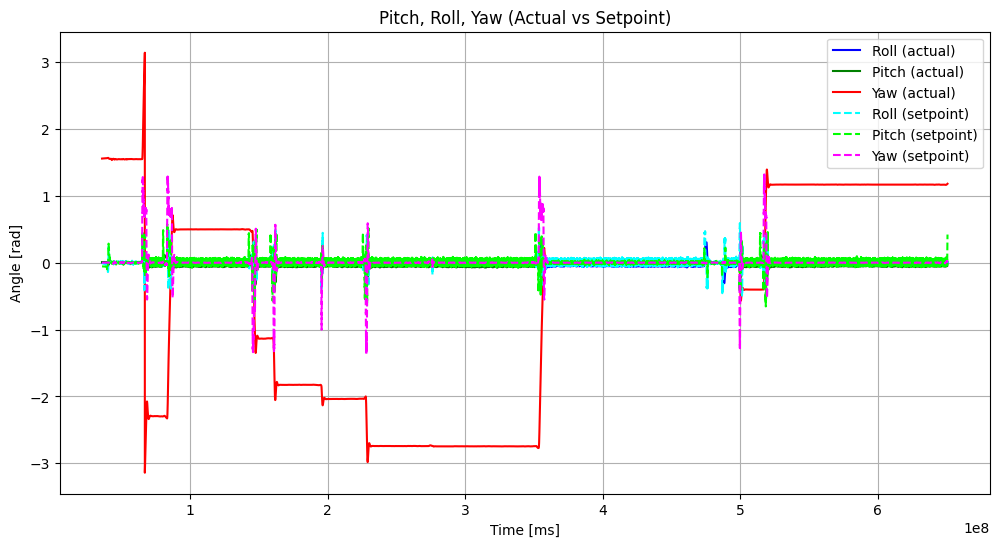

In [132]:
if __name__ == "__main__":
    main()